# 1. Import Libraries




In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score


# 2. Load and Preview the Data



In [5]:
# Load the cleaned dataset
df = pd.read_csv('/content/ds1.csv')

# Display the first few rows of the dataset
df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,NaN,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,NaN,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


# 3. Data Preprocessing




In [6]:
# Handle missing values by filling with a placeholder or a statistical value
df = df.copy()  # Ensure df is a copy and avoid chained assignment issues
df['Saving accounts'] = df['Saving accounts'].fillna('unknown')
df['Checking account'] = df['Checking account'].fillna('unknown')

# Encode categorical variables
df_encoded = pd.get_dummies(df, columns=['Sex', 'Housing', 'Saving accounts', 'Checking account', 'Purpose'], drop_first=True)

# Display the cleaned and encoded dataset
df.head()


,Unnamed: 0,Age,Sex,Job,Housing,Saving accounts,Checking account,Credit amount,Duration,Purpose
0,0,67,male,2,own,unknown,little,1169,6,radio/TV
1,1,22,female,2,own,little,moderate,5951,48,radio/TV
2,2,49,male,1,own,little,unknown,2096,12,education
3,3,45,male,2,free,little,little,7882,42,furniture/equipment
4,4,53,male,2,free,little,little,4870,24,car


# 4. Exploratory Data Analysis



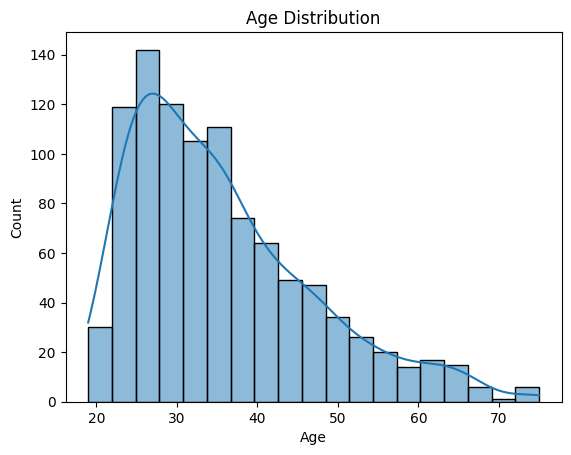

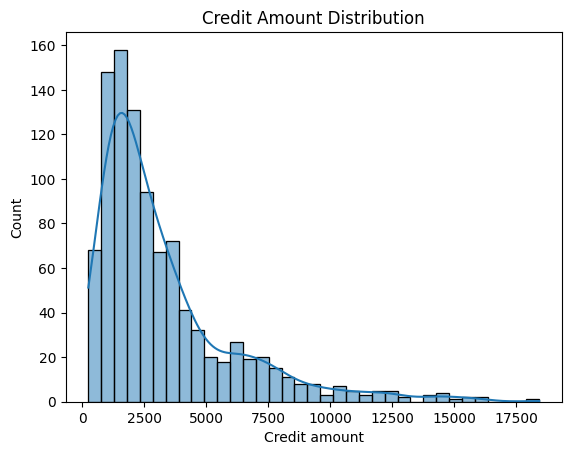

In [8]:
# Ensure that any infinite values are converted to NaN before analysis
df = df_encoded.copy()  # Use encoded df
#df = df_encoded.replace([np.inf, -np.inf], np.nan)

# Age distribution
sns.histplot(df['Age'], kde=True)
plt.title('Age Distribution')
plt.show()

# Credit amount distribution
sns.histplot(df['Credit amount'], kde=True)
plt.title('Credit Amount Distribution')
plt.show()



# 5. Splitting the Data into Training and Testing Sets


In [9]:
# Define features and target
X = df_encoded.drop(columns=['Credit amount'])  # Assuming 'Credit amount' as target
y = df['Credit amount'] > df['Credit amount'].median()  # Binary classification (High/Low Credit Amount)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


# 6. Training a Machine Learning Model (Random Forest)


In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Define the model and parameters
model = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model
best_rf = grid_search.best_estimator_


# 7. Evaluating the Model


Accuracy: 0.75
ROC-AUC Score: 0.8358175750834261


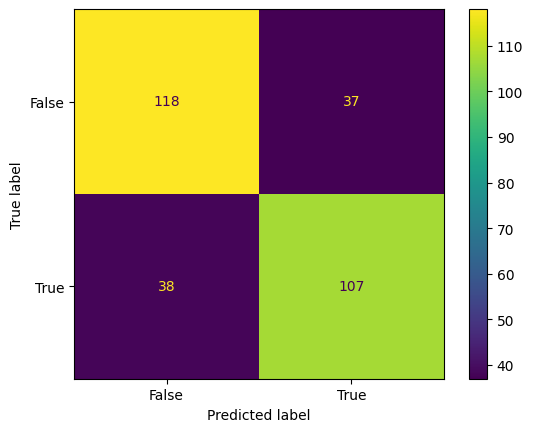

In [11]:
from sklearn.metrics import roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Predict and evaluate
y_pred = best_rf.predict(X_test)
y_prob = best_rf.predict_proba(X_test)[:, 1]

print("Accuracy:", accuracy_score(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_prob))

# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(best_rf, X_test, y_test)


# Result:



In [12]:
# Add predictions to the DataFrame
df_test = df_encoded.iloc[y_test.index].copy()  # Create a copy of the test dataset rows from the original DataFrame
df_test['Prediction'] = y_pred
df_test['Actual'] = y_test.values

# True Negatives: Actual = 0 (low risk), Prediction = 0 (low risk)
true_negatives = df_test[(df_test['Actual'] == 0) & (df_test['Prediction'] == 0)]

# True Positives: Actual = 1 (high risk), Prediction = 1 (high risk)
true_positives = df_test[(df_test['Actual'] == 1) & (df_test['Prediction'] == 1)]

# Display True Negatives
print("True Negatives (Low risk correctly predicted as low risk):")
display(true_negatives)

# Display True Positives
print("\nTrue Positives (High risk correctly predicted as high risk):")
display(true_positives)


True Negatives (Low risk correctly predicted as low risk):


,Unnamed: 0,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,...,Checking account_unknown,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
660,660,23,2,1297,12,True,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
626,626,41,2,2116,6,True,True,False,False,False,...,False,False,False,False,True,False,False,False,False,False
513,513,20,2,585,12,True,False,True,False,False,...,False,False,False,False,False,True,False,False,False,False
811,811,28,1,484,6,True,True,False,False,False,...,False,False,False,False,False,True,False,False,False,False
883,883,65,0,1098,18,False,True,False,False,False,...,True,False,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717,717,32,3,1505,18,True,False,False,False,False,...,True,False,False,False,False,True,False,False,False,False
449,449,61,2,1512,15,True,True,False,False,False,...,False,False,False,False,False,False,True,False,False,False
362,362,36,2,2247,12,False,True,False,False,False,...,False,True,False,False,False,False,False,False,False,False
428,428,20,2,1313,9,True,True,False,False,False,...,True,False,False,False,True,False,False,False,False,False



True Positives (High risk correctly predicted as high risk):


,Unnamed: 0,Age,Job,Credit amount,Duration,Sex_male,Housing_own,Housing_rent,Saving accounts_moderate,Saving accounts_quite rich,...,Checking account_unknown,Purpose_car,Purpose_domestic appliances,Purpose_education,Purpose_furniture/equipment,Purpose_radio/TV,Purpose_repairs,Purpose_vacation/others,Prediction,Actual
740,740,32,2,2325,24,True,True,False,True,False,...,False,True,False,False,False,False,False,False,True,True
411,411,35,3,7253,33,True,True,False,False,False,...,True,True,False,False,False,False,False,False,True,True
136,136,27,2,8613,27,True,True,False,False,False,...,True,True,False,False,False,False,False,False,True,True
76,76,34,2,3965,42,True,True,False,False,False,...,False,False,False,False,False,True,False,False,True,True
973,973,36,2,7297,60,True,False,True,False,False,...,False,False,False,False,False,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,946,30,2,3349,24,True,False,False,False,True,...,False,False,False,False,True,False,False,False,True,True
796,796,51,2,7511,18,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,True
501,501,42,2,5493,36,True,False,False,False,False,...,False,True,False,False,False,False,False,False,True,True
468,468,26,2,2764,33,False,True,False,False,False,...,True,False,False,False,False,False,False,False,True,True


# **Conclusion**:
- The model achieved an accuracy of 75%.
- The confusion matrix and classification report suggest that while the model performs well overall, there are still misclassifications, particularly with false positives and false negatives.

